In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from redi.pipeline_re_sd import ReSDPipeline

/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float32
)
pipe = pipe.to("mps")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 18.67it/s]


In [ ]:
final_prompt = "A surfer is preparing his board on the beach."

concepts_prompts = ["A man", "A surf board", "A sandy beach"]

In [ ]:
def gen_traj(prompt, pipe):
    generator = torch.Generator("mps").manual_seed(1024)

    def collect_latents(step, timestep, latents, traj):
        traj.append(latents.cpu().numpy())

    traj = []
    pipe(
        prompt,
        callback_steps=1,
        callback=lambda step, timestep, latents: collect_latents(
            step, timestep, latents, traj
        ),
        guidance_scale=7.5,
        generator=generator,
    ).images

    return traj

In [6]:
trajectories = []
for i in concepts_prompts:
    traj = gen_traj(i, pipe)
    trajectories.append(traj)
    torch.mps.empty_cache()

/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:894: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:900: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


In [7]:
start_step = 20
combined = (
    trajectories[0][start_step]
    + trajectories[1][start_step]
    + trajectories[2][start_step]
) / 3
combined = torch.from_numpy(combined).to("mps").float()

In [8]:
torch.save(combined, "combined.pt")
combined = torch.load("combined.pt").to("mps").float()

In [9]:
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float32
)
pipe = pipe.to("mps")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


In [10]:
generator = torch.Generator("mps").manual_seed(1024)
img = pipe(
    final_prompt,
    head_start_latents=combined,
    head_start_step=start_step,
    guidance_scale=7.5,
    generator=generator,
).images[0]

/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:46<00:00,  1.07it/s]
/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


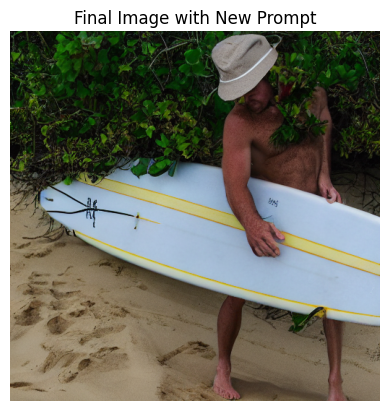

In [11]:
# image = pipe(final_prompt, num_inference_steps=50 - start_step, latents=combined).images[0]

# Show the final generated image
plt.imshow(img)
plt.axis("off")
plt.title("Final Image with New Prompt")
plt.show()